# Monte Carlo Sampling and Estimation of Phase Transition Point

OpenJij performs simulated annealing (SA).
If the temperature is constant, spins can be sampled from the canonical ensemble of that temperature.
The canonical ensemble is:

$$
p(\{\sigma\}) = \frac{\exp(-\beta E(\{\sigma\}))}{Z}, \ Z = \sum_{\{\sigma\}}\exp(-\beta E(\{\sigma\}))
$$

In the following, we use a fully-connected ferromagnetic Ising model:

$$
E(\{\sigma\}) = \frac{J}{N} \sum_{i<j} \sigma_i \sigma_j \ (J<0)
$$

We normalize the Hamiltonian by dividing the energy by the system size $N$.
Also, we set $J = -1$.

In [1]:
# import library
import openjij as oj
import numpy as np
import matplotlib.pyplot as plt

# set sampler
sampler = oj.SASampler(num_reads=100)

# define the fully-connected problem
def fully_connected(n):
    h, J = {}, {}
    for i in range(n-1):
        for j in range(i+1, n):
            J[i, j] = -1/n
    return h, J

# set h and J
h, J = fully_connected(n=500)

Let us calculate the magnetization at each temperature.

$$
m = \frac{1}{N} \sum_i \sigma_i
$$

If the magnetization is closer to 1, the state is in the ordered state (ferromagnetic). Conversely, if it is closer to 0, the state is in the disordered state (paramagnetic).
When the temperature is kept constant, it can be seen that the magnetization approaches 0 at a temperature of around 1.0.
This is because the phase transition theoretically occurs in the infinite size limit.

In [2]:
# create a list of temperatures
temp_list = np.linspace(0.01, 2, 30)

# calculate the magnetization and its dispersion
mag, mag_std = [], []
for temp in temp_list:
    beta = 1.0/temp
    schedule = [[beta, 100]]
    response = sampler.sample_ising(h, J, schedule=schedule)
    mag_list = [np.abs(np.mean(state)) for state in response.states]
    mag_std.append(np.std(mag_list))
    mag.append(np.mean(mag_list))

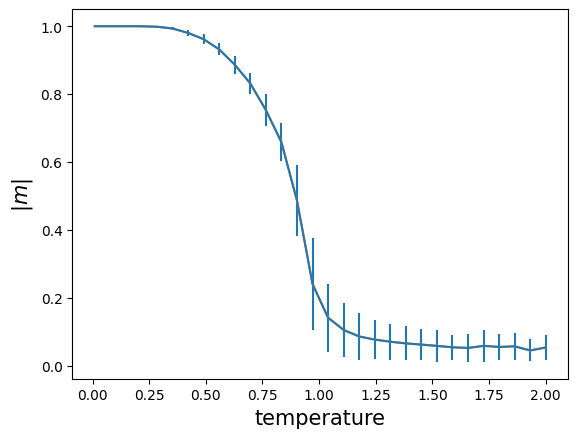

In [3]:
# plot
plt.errorbar(temp_list, mag, yerr=mag_std)
plt.plot(temp_list, mag)
plt.xlabel('temperature', fontsize=15)
plt.ylabel(r'$|m|$', fontsize=15)
plt.show()

**Phase transition** is the phenomenon that changes the value significantly at a specific temperature.
In the present model, it is theoretically proven that a phase transition occurs at a temperature of 1.0 in the thermodynamic limit.  
However, in many cases, it is difficult to study the properties of the phase transition theoretically. For this reason, many methods use Monte Carlo simulations to study the properties of the phase transitions numerically.

## Binder Cumulant

Let us assume that we do not know the phase transition temperature, and let us try to find it as accurately as possible from numerical calculations.
The above figure shows that the magnetization is approaching zero as the temperature increases.
However, it needs to be made clear which temperature is the phase transition point.
This is because the phase transition phenomenon theoretically occurs in a system of infinite size, but the simulation can only handle a finite size, resulting in an error with the theory. This is called the **finite-size effect**.  
It may seem impossible to numerically analyze a system of infinite size.
However, in the field of numerical statistical mechanics, methods have been developed to obtain information on the infinite size limit from finite system sizes.
One of these methods uses the **Binder cumulant**.
Binder cumulant is:

$$U_4 \equiv \frac{1}{2}\left( 3- \frac{\langle m^4\rangle}{\langle m^2\rangle^2} \right)$$

In [4]:
# calculate U_4
def u_4(states):
    m = np.array([np.mean(state) for state in states])
    return 0.5 * (3-np.mean(m**4)/(np.mean(m**2)**2))

We can show that this quantity approaches 1 for ferromagnetic state, where the magnetization approaches 1, and 0 for paramagnetic state, where the magnetization approaches 0.
Furthermore, it is known that the value is independent of system size at the phase transition point.
Therefore, numerical experiments can be performed for several system sizes, and the phase transition point is the point where $U_4$ for several system sizes intersect.
Please check statistical mechanics textbooks for more information.
Let us perform the calculation with OpenJij.

In [5]:
# Define the size of the system as a list
n_list = [40, 80, 120, 160]
# Define temperature by list
temp_list = np.linspace(0.5, 1.5, 30)

# Set sampler
sampler = oj.SASampler(num_reads=300)

u4_list_n = []
for n in n_list:
    # Create instance
    h, J = fully_connected(n)
    u4_temp = []
    for temp in temp_list:
        beta = 1.0/temp
        schedule = [[beta, 100 if temp < 0.9 else 300]]
        response = sampler.sample_ising(h, J, 
                                        schedule=schedule, reinitialize_state=False,
                                        num_reads=100 if temp < 0.9 else 1000
                                       )
        u4_temp.append(u_4(response.states))
    u4_list_n.append(u4_temp)

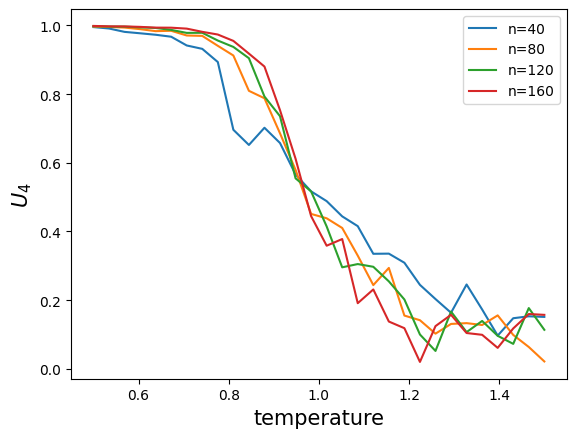

In [6]:
# plot
for n,u4_beta in zip(n_list,u4_list_n):
    plt.plot(temp_list, np.array(u4_beta), label='n={}'.format(n))

plt.legend()
plt.ylabel('$U_4$', fontsize=15)
plt.xlabel('temperature', fontsize=15)
plt.show()

The statistics are not enough, so the data is a little scattered.
However, it can be seen that the data for the four system sizes intersect at a single point around the temperature of 1, which is approximately the phase transition point.  
Estimation of the phase transition point by Binder cumulant is a common method used in numerical analysis.

> In academic research, it is necessary to obtain sufficient statistics, and of course, error evaluation (calculation of error bars) must be done more precisely.
Since the present calculations are only an overview, the exact error evaluations are omitted.

## Summary

We have shown how to perform Monte Carlo sampling using OpenJij.
We applied it to an estimation of phase transitions point.
OpenJij can be used for various applications depending on your ideas.